# Introduction
The Poisson regression model belongs to a class of models called generlized linear models. In a generlized linear model (GLM), the mean of the response, $\mu$, is modelled as a monotonic (nonlinear) transformation of the explanatory variables, $g(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p)$. The inverse of the transformation $g$ is called the *canonical link function*. In Poisson regression this function is the log function, but in other GLMs different link functions are used. Also, the response may take different distributions, such as the normal or the binomial distribution.

# Reading data into python
First we import the pandas package (Pandas stands for panel datas), more info can be found at Pandas website www.pandas.org

In [0]:
import pandas as pd

The csv (comma separated values) file is dat5007.csv and is delimited with ";". We can use the pandas function read_table to load the data into the variable df.

In [0]:
df = pd.read_table("dat5007.csv",sep=";",)

In [3]:
df.dtypes

År                                      float64
Dödade                                  float64
Skadade                                 float64
Varav svårt skadade                      object
Bilar i trafik vid årets slut (1000)    float64
Bensinleveranser (1000 m3)               object
Invånare vid årets slut (1000)          float64
Dödade per 100 000 Bilar                float64
Dödade per 100 000 Invånare              object
Unnamed: 9                              float64
Unnamed: 10                             float64
dtype: object

Now, some of the columns have bad values, like spaces and thus pandas cannot see that the column is a numeric value, we can force this to happen using the to_numeric function.

In [0]:
df['Varav svårt skadade'] = pd.to_numeric(df['Varav svårt skadade'],errors='coerce')
df['Bensinleveranser (1000 m3)'] = pd.to_numeric(df['Bensinleveranser (1000 m3)'],errors='coerce')
df['Dödade per 100 000 Invånare'] = pd.to_numeric(df['Dödade per 100 000 Invånare'],errors='coerce')

A final check confirms that all columns are now numeric i.e. float64 (64 bit floating point value)

In [5]:
df.dtypes

År                                      float64
Dödade                                  float64
Skadade                                 float64
Varav svårt skadade                     float64
Bilar i trafik vid årets slut (1000)    float64
Bensinleveranser (1000 m3)              float64
Invånare vid årets slut (1000)          float64
Dödade per 100 000 Bilar                float64
Dödade per 100 000 Invånare             float64
Unnamed: 9                              float64
Unnamed: 10                             float64
dtype: object

The csv file contains some extra columns that are of no use, so lets drop those

In [0]:
df = df.drop(labels=["Unnamed: 9","Unnamed: 10"],axis=1)

The df variable now contains a Pandas dataframe which contains all the data, we can take a look at that data using the head function, the value we specify tells pandas how many lines we want to preview.

In [7]:
df.head(4)

,År,Dödade,Skadade,Varav svårt skadade,Bilar i trafik vid årets slut (1000),Bensinleveranser (1000 m3),Invånare vid årets slut (1000),Dödade per 100 000 Bilar,Dödade per 100 000 Invånare
0,1950.0,595.0,10583.0,NaN,345.0,NaN,7042.0,172.463768,8.449304
1,1951.0,708.0,11240.0,NaN,410.0,NaN,7099.0,172.682927,9.973236
2,1952.0,750.0,12846.0,NaN,466.0,NaN,7151.0,160.944206,10.488044
3,1953.0,921.0,15033.0,NaN,542.0,NaN,7192.0,169.926199,12.805895


# Visualizations
Try plotting the number of people killed vs. number of cars and the petrol consumption. Do you see any connection?

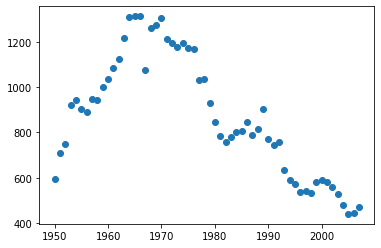

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df['År'],df['Dödade'])

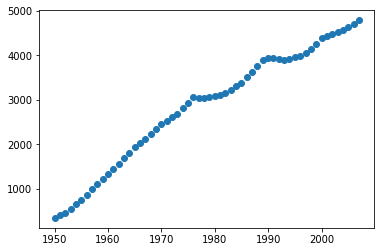

In [9]:
plt.scatter(df['År'],df['Bilar i trafik vid årets slut (1000)'])

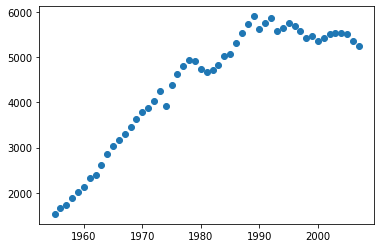

In [10]:
plt.scatter(df['År'],df['Bensinleveranser (1000 m3)'])

From the plot it can be seen that the trend of increasing killed is broken around year 1965. And from year 1970 the number starts to decrease. Why did the number of people killed increase in years 1950-1965? What was the reason for the brake of the increasing trend? (Hint: right-side driving (1967), front seat-belts in new cars (1969), mandatory use of front seat-belts (1975)).

# The Poisson regression model
Consider a sequence of count data, $n_i$, $i=1,\ldots, k$, for some event, i.e. the number of perished in traffic accidents in a year. This count data is assumed to be observations from random variables $N_i \in \text{Po}(\mu_i)$, (called responses or dependent variables) with mean value $\mu_i = \mu_i(x_{i1}, \ldots , x_{ip})$. The variables, $x_{i1}, . . . , x_{ip}$, are called explanatory variables and are assumed to measure factors that influence the count data.
We restrict $\mu_i$ to be a log-linear function,
$$\mu_i = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}).$$
Thus the probability that $N_i = n$ is,
$$
  P(N_i = n) = \frac{e^{-\mu_i} \mu_i^n}{n!}
$$

# Poisson regression of traffic data

We will now try to fit the Poisson regression model to the traffic data of the number of people killed in road accidents. Above, we could see that there was a break in the trend of increasing number people killed around year 1965-1975, mainly because of the improvement in car safety due to the use of safety belts. Because of this it seems reasonable introduce an explanatory variable that captures this.

In [0]:
df['Säkerhetsbälte'] = (df['År'] > 1975)*1

## Removing NaNs
Usually it is prudent to remove the NaN (Not a Number) in some way, usually it is because data is missing, sometimes we did something wrong in transforming the data or reading the data. In this case it is simply missing data. There are two rows at the end with no data (probably the csv is formatted incorrectly at the end. Furthermore Severely injured and Petrol deliveries (Svårt skadade & Bensinleveranser) starts from 1956 and forwards, so lets drop the na's. This will give us only a few years of data loss at the beginning.

In [0]:
df = df.dropna()

In [13]:
df.head(5)

,År,Dödade,Skadade,Varav svårt skadade,Bilar i trafik vid årets slut (1000),Bensinleveranser (1000 m3),Invånare vid årets slut (1000),Dödade per 100 000 Bilar,Dödade per 100 000 Invånare,Säkerhetsbälte
6,1956.0,889.0,19220.0,3275.0,855.0,1657.0,7341.0,103.976608,12.110067,0
7,1957.0,946.0,19934.0,3277.0,987.0,1738.0,7393.0,95.845998,12.795888,0
8,1958.0,941.0,20859.0,3104.0,1098.0,1893.0,7436.0,85.701275,12.654653,0
9,1959.0,1000.0,21475.0,3137.0,1216.0,2011.0,7471.0,82.236842,13.385089,0
10,1960.0,1036.0,21536.0,2983.0,1324.0,2127.0,7498.0,78.247734,13.817018,0


As showed in the computer example in the previous lecture, the Poissonregression is part of GLM (Generalized Linear Model) which is provided by the statsmodels package. We start with the customary imports (please see the documentation at https://www.statsmodels.org/stable/index.html for more info.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Lets start with building a simple model, number of killed vs the year.

In [0]:
mod1 = smf.glm(formula="Dödade ~ År",
               data=df,
               family=sm.families.Poisson()).fit()

In [16]:
mod1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            1679.9524
Link Function:      log              BIC:            1046.1109
Dependent Variable: Dödade           Log-Likelihood: -837.98  
Date:               2020-04-21 09:18 LL-Null:        -2399.1  
No. Observations:   51               Deviance:       1238.8   
Df Model:           1                Pearson chi2:   1.21e+03 
Df Residuals:       49               Scale:          1.0000   
Method:             IRLS                                      
--------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept     42.2371   0.6412  65.8705 0.0000 40.9803 43.4938
År            -0.0179   0.0003 -55.2359 0.0000 -0.0185 -0.0173
==============================================================

"""

In [0]:
predictions1 = mod1.predict(df)

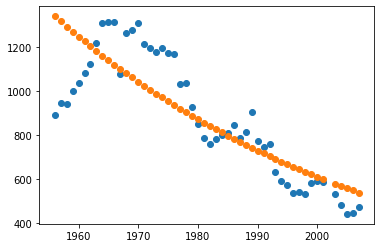

In [18]:
plt.scatter(df['År'],df['Dödade'])
plt.scatter(df['År'],predictions1)

As we can see above, the year alone does not seem to capture the curve. Let us try some more explanatory variables. But before that let us do something which is essential for statsmodels, i.e. that the column names does not contain spaces and (). We can do that by looping over all column names and replacing the spaces with _ and (,) with _. This type of for loop is called a list comprehension, see https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions.

In [0]:
df.columns = [col.replace(' ','_') for col in df.columns]
df.columns = [col.replace('(','_').replace(')','_') for col in df.columns]

Lets try to include Cars at the end of the year

In [0]:
mod2 = smf.glm(formula="Dödade ~ År + Bilar_i_trafik_vid_årets_slut__1000_",
               data=df,
               family=sm.families.Poisson()).fit()

In [21]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Dödade   No. Observations:                   51
Model:                            GLM   Df Residuals:                       48
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -311.72
Date:                Tue, 21 Apr 2020   Deviance:                       186.25
Time:                        09:18:57   Pearson chi2:                     187.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              163.2669      3.804     42.923      0.000     155.812     170.722
År                                      -0.0803      0.002    -40.971      0.000      -0.084      -0.076
Bilar_i_trafik_vid_årets_slut__1000_     0.0008    2.6e-05     32.257      0.000       0.001       0.001
========================================================================================================
"""

In [0]:
predictions2 = mod2.predict(df)

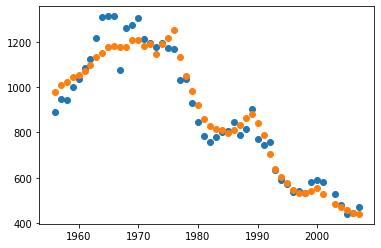

In [23]:
plt.scatter(df['År'],df['Dödade'])
plt.scatter(df['År'],predictions2)

This looks much better, but lets see if we can do more, lets try adding Säkherhetsbälte (Seatbelt) and Högertrafik (Right traffic) as a feature

In [0]:
df['Högertrafik'] = (df['År'] > 1969)*1

In [0]:
# You try to write the code

mod3 = smf.glm(formula="",
               data=df,
               family=sm.families.Poisson()).fit()

In [26]:
mod3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Generalized linear model
========================================================================================
Model:                       GLM                       AIC:                     561.4370
Link Function:               log                       BIC:                     -66.6090
Dependent Variable:          Dödade                    Log-Likelihood:          -275.72 
Date:                        2020-04-21 09:18          LL-Null:                 -2399.1 
No. Observations:            51                        Deviance:                114.25  
Df Model:                    4                         Pearson chi2:            114.    
Df Residuals:                46                        Scale:                   1.0000  
Method:                      IRLS                                                       
----------------------------------------------------------------------------------------
                                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------------
Intercept                            165.7157   4.4415  37.3104 0.0000 157.0105 174.4210
År                                    -0.0816   0.0023 -35.6571 0.0000  -0.0861  -0.0771
Bilar_i_trafik_vid_årets_slut__1000_   0.0009   0.0000  28.2844 0.0000   0.0009   0.0010
Säkerhetsbälte                        -0.1094   0.0179  -6.1257 0.0000  -0.1444  -0.0744
Högertrafik                           -0.0829   0.0198  -4.1932 0.0000  -0.1217  -0.0442
========================================================================================

"""

In [0]:
predictions3 = mod3.predict(df)

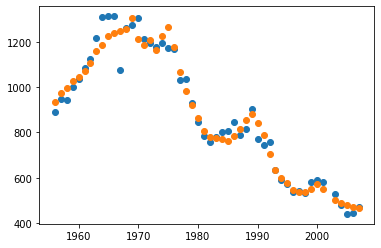

In [28]:
plt.scatter(df['År'],df['Dödade'])
plt.scatter(df['År'],predictions3)

Now we are getting very close, lets see what happens when we add the amount of petrol consumption (Assuming that the mean fuel consumption of a car has been constant over the years — a 1970-year model of a Volvo used about 10l per 100 km which is approximately the same as for a model from, say year 2000. However, the engine of the model from 2000 probably has more horsepower.).

In [29]:
df.columns

Index(['År', 'Dödade', 'Skadade', 'Varav_svårt_skadade',
       'Bilar_i_trafik_vid_årets_slut__1000_', 'Bensinleveranser__1000_m3_',
       'Invånare_vid_årets_slut__1000_', 'Dödade_per_100_000_Bilar',
       'Dödade_per_100_000_Invånare', 'Säkerhetsbälte', 'Högertrafik'],
      dtype='object')

It's now time for you to do the work
* Write the code to:
    * Fit the model and store into variable mod4
    * Print the model summary
    * Do a scatter plot with the true values and the predicted values as you have seen for mod1-3

Does it look familiar? Did we do any better with that information?

# Model selection - deviance
It is not always easy to decide, just by looking at a plot, which model to choose. Even though adding more variables improves the fit, it also increases the uncertainty of the estimates. One method to choose complexity of the model is to use the deviance and a hypothesis test. Let $\beta^\ast_{\bf p} = (\beta^\ast_0,\beta^\ast_1,\ldots,\beta^\ast_p)$ be the ML estimates of the model parameters $\beta_0,\beta_1,\ldots,\beta_p$ of the full model with p explanatory variables and $\beta^\ast_{\bf q}$ the estimates of a simpler model where only q (where q < p) of the explanatory variables have been used. Then for large k, and under suitable regularity conditions, the deviance
$$
  \text{DEV} = 2 (l(\beta^\ast_{\bf p}) - l(\beta^\ast_{\bf q}))
$$
is approximately $\chi^2(p-q)$ distributed if the less complex model is true. Thus, it is pos- sible to test if the simpler model can be rejected compared to the full model. Quantiles can be found from tables or by **scipy.stats.chi2.ppf**

Thus if $\text{DEV} > \chi^2_\alpha (p-q)$, the difference between log-likelihoods cannot be explained by the statistical variability and hence the simpler model should be rejected. In other words, the more complex model fits data significantly better.

Let us compute this using Eq. (7.14) from the book i.e.
$$
  \text{DEV} = 2 \sum_{i=1}^k n_i (\ln(\mu^\ast_{iC})-\ln(\mu^\ast_{iS})
$$
In the above the C corresponds to complex and S corresponds to simple.

In [45]:
import numpy as np
2*np.sum(df['Dödade']*np.log(predictions2)-df['Dödade']*np.log(predictions1))
# For you who are not so familiar with numpy, the np.log is just the 
# natural logarithm applied to each element in the array.
# Also all multiplication is elementwise, so its like .* in Matlab

1052.5204864831048

In [0]:
import scipy.stats as ss
# ss.chi2.ppf
# ppf(q, df, loc=0, scale=1)
# Percent point function (inverse of cdf — percentiles).
# ss.chi2.ppf(q=1-alpha,df=df) represents a the alpha quantile of a chi2 r.v. 
# with df degrees of freedom.

Use the above mentioned `ss.chi2.ppf` to compute the quantile for comparing `mod1` to `mod2` with the deviance computation above. Can we reject the simpler model that only uses Year in favor of a model that uses Year and number of cars?

### More model selection
Do the same for `mod2` vs `mod3` and `mod3` vs `mod4`, what is your final conclusion?

# Conclusion

Is the Poisson regression model doing a good job of describing the number of people killed in traffic?